In [4]:
#Imports
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Load the data
df = pd.read_csv('../data/train_enc.csv')
df.head

<bound method NDFrame.head of       BedroomAbvGr  KitchenAbvGr  LotFrontage   LotArea  OverallQual  \
0         0.163779     -0.211454    -0.220875 -0.207142     0.651479   
1         0.163779     -0.211454     0.460320 -0.091886    -0.071836   
2         0.163779     -0.211454    -0.084636  0.073480     0.651479   
3         0.163779     -0.211454    -0.447940 -0.096897     0.651479   
4         1.390023     -0.211454     0.641972  0.375148     1.374795   
...            ...           ...          ...       ...          ...   
1455      0.163779     -0.211454    -0.357114 -0.260560    -0.071836   
1456      0.163779     -0.211454     0.687385  0.266407    -0.071836   
1457      1.390023     -0.211454    -0.175462 -0.147810     0.651479   
1458     -1.062465     -0.211454    -0.084636 -0.080160    -0.795151   
1459      0.163779     -0.211454     0.233255 -0.058112    -0.795151   

      OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  \
0       -0.517200   1.050994  

In [6]:
# Split the data into training and validation sets
train, validation = train_test_split(df, test_size=0.2, random_state=200, shuffle=True)

print(train.shape)
print(validation.shape)

(1168, 264)
(292, 264)


In [7]:
target = 'SalePrice'
X_train = train.drop(target, axis=1)
y_train = train[target]

X_validation = validation.drop(target, axis=1)
y_validation = validation[target]

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((1168, 263), (1168,), (292, 263), (292,))

## Train the model (with default hyperparameters)

In [8]:
# Create the model
gbr_model = GradientBoostingRegressor()

gbr_model.fit(X_train, y_train)

# R2 score
gbr_model.score(X_validation, y_validation)

0.8395555921806054

Note that the score is already better than simple Random Forest Regressor. This is because Gradient Boosting is an ensemble method that builds trees sequentially, where each tree tries to correct the errors of the previous one. This is different from Random Forest, where each tree is built independently.

## Hyperparameter tuning using GridSearchCV

In [70]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to test
param_grid_extended = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'learning_rate': [0.01, 0.05, 0.01, 0.5, 1],
    'max_depth': [3, 5, 7]
}

simple_param_grid = {
    'n_estimators': [2500, 2750, 3000],
    'learning_rate': [0.5, 0.05],
    'max_depth': [2, 3, 5, 7]
}

param_grid = {'learning_rate': [0.05, 0.03, 0.02, 0.01],
              'max_depth': [3, 4, 5, 6],
              'min_samples_leaf': [3, 5, 9, 14],
              'max_features': [0.7, 0.5, 0.3, 0.1]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(GradientBoostingRegressor(n_estimators=3000), param_grid, cv=5, scoring='r2', return_train_score=True, n_jobs=-1, verbose=1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Save the best estimator
gbr_model = grid_search.best_estimator_

# Get the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Print the best parameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best parameters:  {'learning_rate': 0.02, 'max_depth': 5, 'max_features': 0.1, 'min_samples_leaf': 3}
Best score:  0.8790886320989756


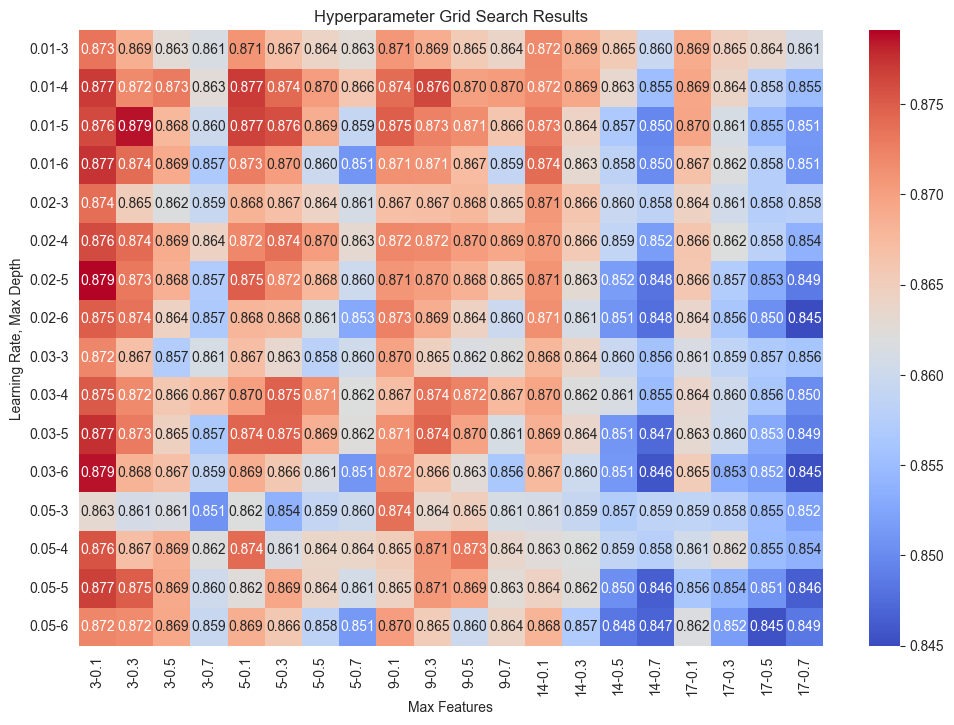

In [71]:
# Reshape the results dataframe to have separate columns for each parameter
results_pivot = results.pivot_table(index=['param_learning_rate', 'param_max_depth'], 
                                    columns=['param_min_samples_leaf', 'param_max_features'], 
                                    values='mean_test_score')

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(results_pivot, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Hyperparameter Grid Search Results')
plt.xlabel('Max Features')
plt.ylabel('Learning Rate, Max Depth')
plt.show()

In [72]:
val_scores = results['mean_test_score'].reshape(4, 5, 4, 4)

# Calculate the mean scores across other hyperparameters
mean_val_scores_lr = np.mean(val_scores, axis=(1, 2, 3))
mean_val_scores_md = np.mean(val_scores, axis=(0, 2, 3))
mean_val_scores_msl = np.mean(val_scores, axis=(0, 1, 3))
mean_val_scores_mf = np.mean(val_scores, axis=(0, 1, 2))

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(8, 20), facecolor='w', edgecolor='k')

# Plot for learning rate
axs[0].plot(param_grid['learning_rate'], mean_val_scores_lr, marker='o', linestyle='-', label='Validation')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Mean R2 Score')
axs[0].set_title('Validation R2 Score by Learning Rate')
axs[0].legend()
axs[0].grid(True)

# Plot for max depth
axs[1].plot(param_grid['max_depth'], mean_val_scores_md, marker='o', linestyle='-', label='Validation')
axs[1].set_xlabel('Max Depth')
axs[1].set_ylabel('Mean R2 Score')
axs[1].set_title('Validation R2 Score by Max Depth')
axs[1].legend()
axs[1].grid(True)

# Plot for min samples leaf
axs[2].plot(param_grid['min_samples_leaf'], mean_val_scores_msl, marker='o', linestyle='-', label='Validation')
axs[2].set_xlabel('Min Samples Leaf')
axs[2].set_ylabel('Mean R2 Score')
axs[2].set_title('Validation R2 Score by Min Samples Leaf')
axs[2].legend()
axs[2].grid(True)

# Plot for max features
axs[3].plot(param_grid['max_features'], mean_val_scores_mf, marker='o', linestyle='-', label='Validation')
axs[3].set_xlabel('Max Features')
axs[3].set_ylabel('Mean R2 Score')
axs[3].set_title('Validation R2 Score by Max Features')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
y_pred_validation = gbr_model.predict(X_validation)

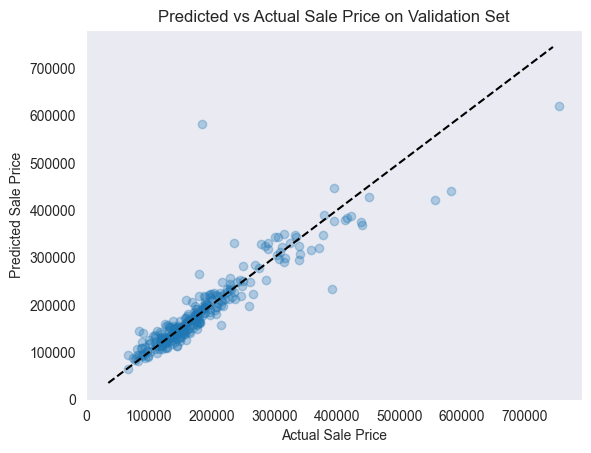

In [13]:
# Plotting
import numpy as np

plt.scatter(y_validation, y_pred_validation, alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs Actual Sale Price on Validation Set')
plt.grid(False)
plt.show()

##### The best parameters are n_estimators=300, learning_rate=0.05, and max_depth=3

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_validation = gbr_model.predict(X_validation)
y_pred_log = np.log(y_pred_validation)
y_actual_log = np.log(y_validation)
rmse = np.sqrt(mean_squared_error(y_actual_log, y_pred_log))
rmse

0.13809195118482478

## Repeat the process with the best parameters

In [22]:
# Perform cross-validation and get scores
r2_scores = cross_val_score(gbr_model, X_train, y_train, cv=5, scoring='r2')

# Print the scores
for score in r2_scores:
    print(score)

0.9298324698982091
0.9168834117196334
0.9167862351032723
0.7579642692229884
0.8770784122828678


In [23]:
# gbr_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
r2_scores = []

# Repeat the process 20 times with the best parameters, shuffling the data each time
for i in range(20):
    train, validation = train_test_split(df, test_size=0.2, random_state=i, shuffle=True)

    target = 'SalePrice'
    train_x = train.drop(target, axis=1)
    train_y = train[target]
    validation_x = validation.drop(target, axis=1)
    validation_y = validation[target]

    # Fit the model
    gbr_model.fit(train_x, train_y)

    score = gbr_model.score(validation_x, validation_y)
    print(score)
    r2_scores.append(score)

0.8924090524022268
0.9193212635213561
0.9126421795841742
0.8691716131108924
0.9065850640190716
0.9125488588573331
0.859632150365412
0.911409465670493
0.8431961296181916
0.9089613798180893
0.9121417864288588
0.8819647775446695
0.8586377584046329
0.7332987115539791
0.8952512245278061
0.9246761152614138
0.7545998684725281
0.9011171343456454
0.939447703662181
0.774680753307997


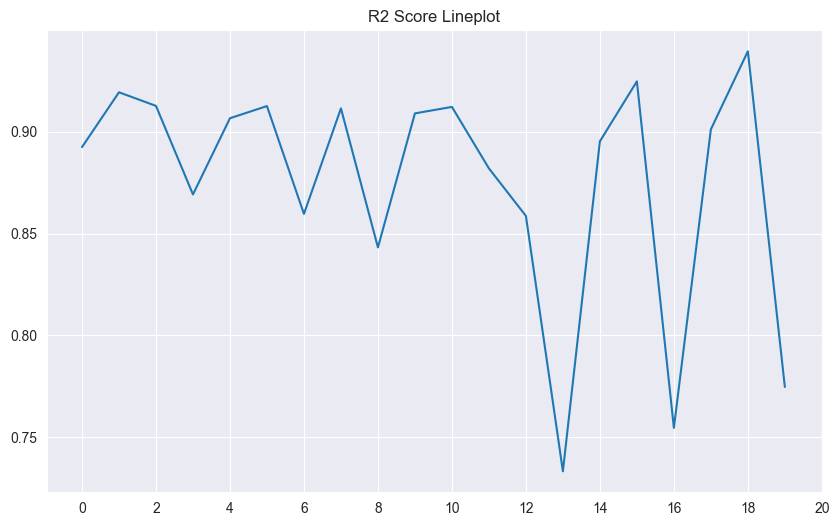

In [24]:
# Plot the r2 scores to show consistency
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(20), y=r2_scores, ax=ax)
ax.set_title('R2 Score Lineplot')
# ax.set_ylim(0.60, 1.0)
ax.set_xticks(range(0, 21, 2))
plt.show()

##### The scores are fairly consistent, so we can be confident in the model's performance.

Shuffling the data allows us to see the variation in the model's performance. The model's performance is consistent across different random states, so we can be confident in the model's performance. The R2 score is consistently above 0.8 (except a couple outliers), which is a good result for this dataset.

## Submission to Kaggle
##### Only run once at the end

In [25]:
# Record predictions for the test set
test = pd.read_csv('../data/test_enc.csv')
test_predictions = gbr_model.predict(test)

# add the Id column to the predictions
df_test = pd.read_csv('../data/test.csv')
test_predictions = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': test_predictions})

# Save the predictions to a CSV file
test_predictions.to_csv('../gbr_test_predictions_3000.csv', index=False)

test_predictions

,Id,SalePrice
0,1461,126595.911386
1,1462,164761.184518
2,1463,186357.050920
3,1464,203804.539889
4,1465,192158.485636
...,...,...
1454,2915,81147.782062
1455,2916,79254.715782
1456,2917,168884.010234
1457,2918,114730.261628
